In the model 
$$y\sim N(X\beta,\sigma^2I)$$
$$\beta|\gamma\sim N(0,D_\gamma)$$
where $$D_\gamma = diag((1-\gamma_j)\sigma_0^2 + \gamma_j\sigma^2_1)$$
$$p(\gamma_j = 1) = \pi_1$$
$$\sigma^2\sim IG(a,b)$$

The SSVS iteratively samples:

1. 
$$\beta\sim N(\frac{A}{\sigma^2} X^T y, A)$$ 
where 
$$A = (X^TX/\sigma^2 + D_\gamma^{-1})^{-1}$$

2. $$\sigma^2\sim IG(n/2 + a, ||y-X\beta||^2/2 + b)$$

3. $$p(\gamma_j = 1) = \frac{p_1}{p_0+p_1}$$
 where 

 $$p_1 = \pi_1 p(\beta|\gamma_j=1,\gamma_{-j})$$
 $$p_0 = \pi_0 p(\beta|\gamma_j=0,\gamma_{-j})$$



In [1]:
from scipy.optimize import fsolve
from scipy.optimize import bisect
import numpy as np
from scipy.stats import invgamma  
from scipy.stats import multivariate_normal
from scipy.stats import bernoulli
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
'''
The posterior is also a Gaussian mixture of two components. The posterior mean is easy to compute. However, the 
quantile doesn't have close form solution. Use fsolve in scipy.optimize to solve equations for quantile.
'''
def computeNormalStats(sigma, sigma0, sigma1, theta, Y):
# sigma is noise variance
# theta is prop of non 0's
# Y is a scalar
    tau = 1 / sigma**2
    tau0 = 1 / sigma0**2
    tau1 = 1 / sigma1**2
    tau0_ = tau0 + tau 
    tau1_ = tau1 + tau 
    theta_ = theta / (theta + (1-theta) * np.sqrt(tau1_*tau0/(tau0_*tau1)) \
        * np.exp(-0.5 * tau**2 * (tau0_-tau1_) / (tau0_*tau1_) * Y**2))
    mu1 = tau / tau1_ * Y 
    mu0 = tau / tau0_ * Y 
    true_mean = theta_ * mu1 + (1-theta_) * mu0
    # Use different initial values according to Y to avoid solver failure.
    if np.abs(Y) > 4:
        q025 = fsolve(lambda x: theta_ * norm.cdf(x, mu1, (1/tau1_)**0.5) + (1-theta_) * norm.cdf(x, mu0, (1/tau0_)**0.5) - 0.025, Y)
        q975 = fsolve(lambda x: theta_ * norm.cdf(x, mu1, (1/tau1_)**0.5) + (1-theta_) * norm.cdf(x, mu0, (1/tau0_)**0.5) - 0.975, Y)
    else:
        q025 = fsolve(lambda x: theta_ * norm.cdf(x, mu1, (1/tau1_)**0.5) + (1-theta_) * norm.cdf(x, mu0, (1/tau0_)**0.5) - 0.025, 0)
        q975 = fsolve(lambda x: theta_ * norm.cdf(x, mu1, (1/tau1_)**0.5) + (1-theta_) * norm.cdf(x, mu0, (1/tau0_)**0.5) - 0.975, 0)        
    return true_mean, q025, q975

In [2]:
def computeNormalStats_vec(sigma, sigma0, sigma1, theta, Y):
    # Y is a vector now
    true_mean = np.zeros(len(Y))
    true_q025 = np.zeros(len(Y))
    true_q975 = np.zeros(len(Y))

    for i in range(len(Y)):
        true_mean[i], true_q025[i], true_q975[i] = computeNormalStats(sigma, sigma0, sigma1, theta,Y[i])
    return true_mean,true_q025,true_q975

In [3]:

def ssvs(X,y,pi0,var0,var1,ig_a=0.01,ig_b=0.01,n_burnin=500,n_post=10000,printevery = 10):
    n,p = X.shape
    XtX = np.dot(X.T,X)
    Xty = np.dot(X.T,y)
    beta_draws = np.zeros((n_burnin + n_post,p))
    gamma_draws = np.zeros((n_burnin + n_post,p))
    sigma2_draws = np.zeros(n_burnin + n_post)
    gamma = np.zeros(p)
    y = np.squeeze(y)
    sigma2 = np.var(y)
    
    for i in range(n_burnin + n_post):
        if(i%printevery==0):
            print(' '.join(['drawing sample',str(i)]))
        # sample beta
        d_inv = 1/(gamma*var1 + (1-gamma)*var0)
        A = np.linalg.inv(XtX/sigma2 + np.diag(d_inv))
        beta = np.random.multivariate_normal(np.squeeze(np.matmul(A/sigma2,Xty)),A)
        sigma2 = invgamma.rvs(a=n/2+ig_a,scale=sum((y-np.matmul(X,beta))**2)/2+ig_b)
        for j in range(p):
            d1 = (gamma*var1 + (1-gamma)*var0)
            d1[j] = var1
            d0 = (gamma*var1 + (1-gamma)*var0)
            d0[j] = var0
            p1 = (1-pi0) * multivariate_normal.pdf(beta, mean=np.zeros(p), cov=np.diag(d1))
            p0 = pi0 * multivariate_normal.pdf(beta, mean=np.zeros(p), cov=np.diag(d0))
            gamma[j] = bernoulli.rvs(p1/(p1+p0), size=1)
        beta_draws[i,:] = beta
        gamma_draws[i,:] = gamma
        sigma2_draws[i] = sigma2
    return {'beta':beta_draws[n_burnin:,:],'gamma':gamma_draws[n_burnin:,:],'sigma2':sigma2_draws[n_burnin:]}
        


In [4]:
def ssvs_I_fast(y,pi0,var0,var1,sigma2,fix_sigma2=True,ig_a=0.01,ig_b=0.01,n_burnin=500,n_post=10000,printevery = 10):
    n = y.shape[0]
    p = n
    #n,p = X.shape
    #XtX = np.dot(X.T,X)
    #Xty = np.dot(X.T,y)
    beta_draws = np.zeros((n_burnin + n_post,p))
    gamma_draws = np.zeros((n_burnin + n_post,p))
    sigma2_draws = np.zeros(n_burnin + n_post)
    gamma = np.zeros(p)
    y = np.squeeze(y)
    if not fix_sigma2:
        sigma2 = np.var(y)
    
    for i in range(n_burnin + n_post):
        if(i%printevery==0):
            print(' '.join(['drawing sample',str(i)]))
        # sample beta
        d_inv = 1/(gamma*var1 + (1-gamma)*var0)
        # A = np.linalg.inv(XtX/sigma2 + np.diag(d_inv))
        A = 1/(1/sigma2 + d_inv)
        beta = np.random.normal(A*y/sigma2,np.sqrt(A))
        if not fix_sigma2:
            sigma2 = invgamma.rvs(a=n/2+ig_a,scale=sum((y-beta)**2)/2+ig_b)
        for j in range(p):
            d1 = (gamma*var1 + (1-gamma)*var0)
            d1[j] = var1
            p1 = (1-pi0) * np.prod(norm.pdf(beta, loc=0, scale=np.sqrt(d1)))
            
            d1[j] = var0
            p0 = pi0 * np.prod(norm.pdf(beta, loc=0, scale=np.sqrt(d1)))
            
            gamma[j] = bernoulli.rvs(p1/(p1+p0), size=1)
        beta_draws[i,:] = beta
        gamma_draws[i,:] = gamma
        sigma2_draws[i] = sigma2
    return {'beta':beta_draws[n_burnin:,:],'gamma':gamma_draws[n_burnin:,:],'sigma2':sigma2_draws[n_burnin:]}
        

In [5]:
def gen_data(n,p,pi0,var0,var1,sigma2,XI = True):
    beta0 = np.random.normal(0,np.sqrt(var0),p)
    beta1 = np.random.normal(0,np.sqrt(var1),p)
    gamma = bernoulli.rvs(1-pi0, size=p)
    beta = beta1 * gamma + (1-gamma) * beta0
    if XI:
        y = beta + np.random.normal(0,np.sqrt(sigma2),p)
        return {'beta':beta,'y':y,'X':np.diag(np.ones(p)),'gamma':gamma}
    else:
        X = np.random.normal(size=(n,p))
        beta = np.reshape(beta,(p,1))
        y = np.matmul(X,beta) + np.reshape(np.random.normal(0,np.sqrt(sigma2),n),(n,1))
        return {'beta':np.squeeze(beta),'y':np.squeeze(y),'X':X,'gamma':gamma}

## Dense Design matrix

In [5]:
n = 100
p = 20
pi0 = 0.8
var0 = 1e-4
var1 = 4
sigma2 = 1
datax = gen_data(n,p,pi0,var0,var1,sigma2,XI=False)
plt.plot(datax['beta'])

fit = ssvs(datax['X'],datax['y'],pi0,var0,var1,
ig_a=0.01,ig_b=0.01,n_burnin=1000,
n_post=5000,
printevery = 1000)
upper_ci = np.apply_along_axis(np.quantile,0,fit['beta'],q=0.975)
lower_ci = np.apply_along_axis(np.quantile,0,fit['beta'],q=0.025)
pm = np.apply_along_axis(np.mean,0,fit['beta'])
res = pd.DataFrame({'true_beta':np.squeeze(datax['beta']),
'ols': np.squeeze(np.matmul(np.linalg.inv(np.matmul(datax['X'].T,datax['X'])),np.matmul(datax['X'].T,datax['y']))),
'posterior_mean':pm,
'lower':lower_ci,
'upper':upper_ci})
res

idx = [i for i in range(p)]
order_idx = np.argsort(datax['beta'])
fig, ax = plt.subplots()
ax.scatter(idx,pm[order_idx],s=1,color='black')
ax.fill_between(idx,(lower_ci)[order_idx], (upper_ci)[order_idx], color='b', alpha=.1)
ax.scatter(idx,datax['beta'][order_idx],s=0.8,color='red',marker='v')
ax.legend(['posterior mean','95% credible set','True beta'])


NameError: name 'gen_data' is not defined

drawing sample 0
drawing sample 1000
drawing sample 2000
drawing sample 3000
drawing sample 4000
drawing sample 5000


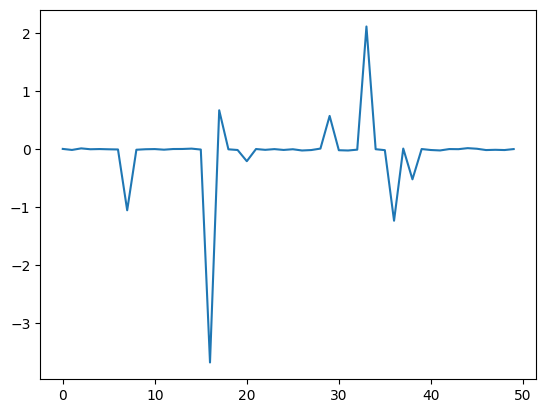

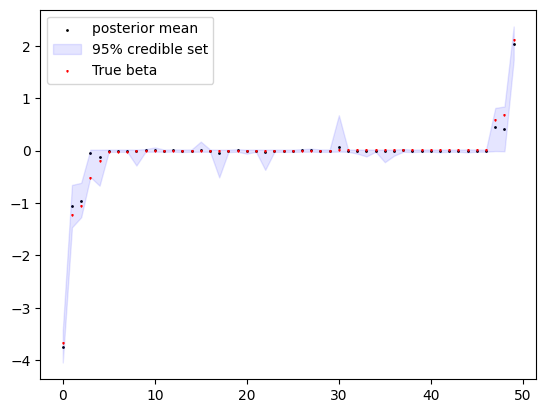

In [ ]:
n = 50
p = 50
pi0 = 0.8
var0 = 1e-4
var1 = 4
sigma2 = 1
datax = gen_data(n,p,pi0,var0,var1,sigma2,XI=False)
plt.plot(datax['beta'])

fit = ssvs(datax['X'],datax['y'],pi0,var0,var1,
ig_a=0.01,ig_b=0.01,n_burnin=1000,
n_post=5000,
printevery = 1000)

upper_ci = np.apply_along_axis(np.quantile,0,fit['beta'],q=0.975)
lower_ci = np.apply_along_axis(np.quantile,0,fit['beta'],q=0.025)
pm = np.apply_along_axis(np.mean,0,fit['beta'])
res = pd.DataFrame({'true_beta':np.squeeze(datax['beta']),
'ols': np.squeeze(np.matmul(np.linalg.inv(np.matmul(datax['X'].T,datax['X'])),np.matmul(datax['X'].T,datax['y']))),
'posterior_mean':pm,
'lower':lower_ci,
'upper':upper_ci})
res

idx = [i for i in range(p)]
order_idx = np.argsort(datax['beta'])
fig, ax = plt.subplots()
ax.scatter(idx,pm[order_idx],s=1,color='black')
ax.fill_between(idx,(lower_ci)[order_idx], (upper_ci)[order_idx], color='b', alpha=.1)
ax.scatter(idx,datax['beta'][order_idx],s=0.8,color='red',marker='v')
ax.legend(['posterior mean','95% credible set','True beta'])

## Diagonal Design matrix

We set $\pi_0=0.95,\sigma^2_0 = 0.0001,\sigma^2_1 = 5,\sigma^2 = 1$

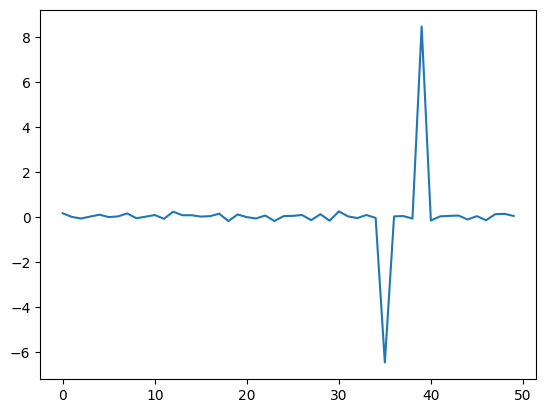

In [22]:
import random
random.seed(2023)
n = 50
p = n
pi0 = 0.95
var0 = 0.01
var1 = 25
sigma2 = 1
datax = gen_data(n,p,pi0,var0,var1,sigma2,XI=True)
plt.plot(datax['beta'])

In [23]:
# get true posterior mean, and credible set
true_pm, true_q025,true_q975 = computeNormalStats_vec(np.sqrt(sigma2),np.sqrt(var0),np.sqrt(var1),1-pi0,datax['y'])

In [24]:
fit = ssvs_I_fast(datax['y'],pi0,var0,var1,sigma2,n_burnin=1000,n_post=5000,printevery = 1000)

drawing sample 0
drawing sample 1000
drawing sample 2000
drawing sample 3000
drawing sample 4000
drawing sample 5000


In [25]:
pred_q975 = np.apply_along_axis(np.quantile,0,fit['beta'],q=0.975)
pred_q025 = np.apply_along_axis(np.quantile,0,fit['beta'],q=0.025)
pm = np.apply_along_axis(np.mean,0,fit['beta'])
# res = pd.DataFrame({'true_beta':np.squeeze(datax['beta']),
# 'ols': np.squeeze(np.matmul(np.linalg.inv(np.matmul(datax['X'].T,datax['X'])),np.matmul(datax['X'].T,datax['y']))),
# 'posterior_mean':pm,
# 'lower':lower_ci,
# 'upper':upper_ci})

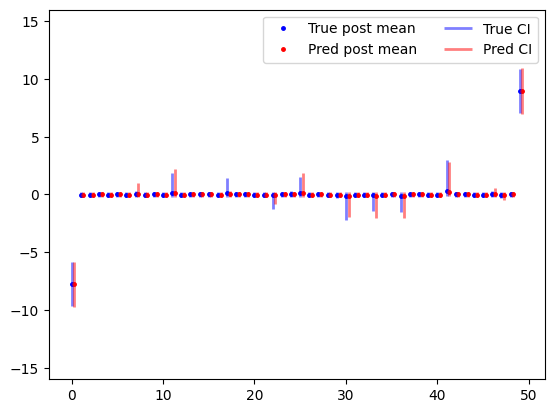

In [26]:
idx = np.arange(n)
order_idx = np.argsort(datax['beta'])
plt.subplot()
plt.plot(idx, true_pm[order_idx], '.b', ms=5)
plt.plot(idx+0.3, pm[order_idx], '.r', ms=5)
plt.vlines(idx, true_q025[order_idx], true_q975[order_idx], color='blue', alpha=0.5, lw=2)
plt.vlines(idx+0.3, pred_q025[order_idx], pred_q975[order_idx], color='red', alpha=0.5, lw=2)
plt.legend(['True post mean', 'Pred post mean', 'True CI', 'Pred CI'], ncol=2)
plt.ylim(-16,16)
plt.show()

drawing sample 0
drawing sample 1000
drawing sample 2000
drawing sample 3000
drawing sample 4000
drawing sample 5000


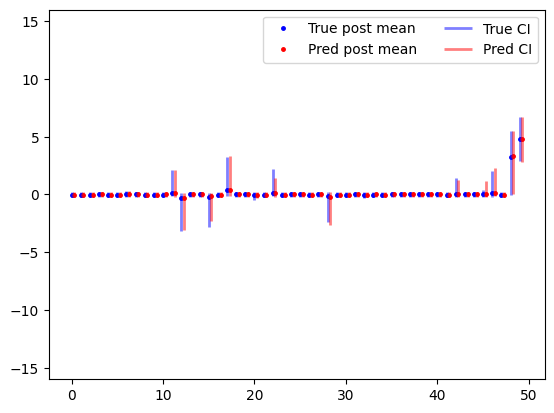

In [38]:
n = 50
p = n
pi0 = 0.95
var0 = 0.01
var1 = 25
sigma2 = 1
datax = gen_data(n,p,pi0,var0,var1,sigma2,XI=True)

fit = ssvs_I_fast(datax['y'],pi0,var0,var1,sigma2,n_burnin=1000,n_post=5000,printevery = 1000)
# get true posterior mean, and credible set
true_pm, true_q025,true_q975 = computeNormalStats_vec(np.sqrt(sigma2),np.sqrt(var0),np.sqrt(var1),1-pi0,datax['y'])
pred_q975 = np.apply_along_axis(np.quantile,0,fit['beta'],q=0.975)
pred_q025 = np.apply_along_axis(np.quantile,0,fit['beta'],q=0.025)
pm = np.apply_along_axis(np.mean,0,fit['beta'])

idx = np.arange(n)
order_idx = np.argsort(datax['beta'])
plt.subplot()
plt.plot(idx, true_pm[order_idx], '.b', ms=5)
plt.plot(idx+0.3, pm[order_idx], '.r', ms=5)
plt.vlines(idx, true_q025[order_idx], true_q975[order_idx], color='blue', alpha=0.5, lw=2)
plt.vlines(idx+0.3, pred_q025[order_idx], pred_q975[order_idx], color='red', alpha=0.5, lw=2)
plt.legend(['True post mean', 'Pred post mean', 'True CI', 'Pred CI'], ncol=2)
plt.ylim(-16,16)
plt.show()

drawing sample 0
drawing sample 1000
drawing sample 2000
drawing sample 3000
drawing sample 4000
drawing sample 5000


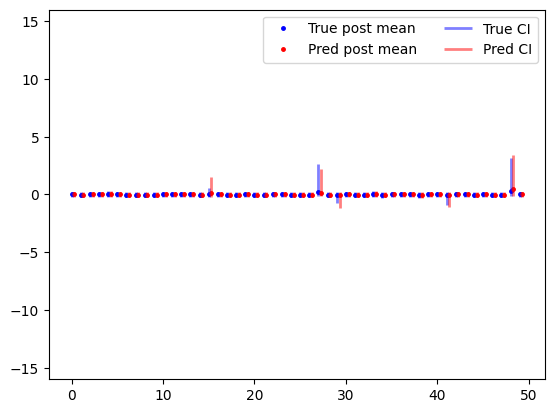

In [39]:
n = 50
p = n
pi0 = 0.95
var0 = 0.01
var1 = 25
sigma2 = 1
datax = gen_data(n,p,pi0,var0,var1,sigma2,XI=True)

fit = ssvs_I_fast(datax['y'],pi0,var0,var1,sigma2,n_burnin=1000,n_post=5000,printevery = 1000)
# get true posterior mean, and credible set
true_pm, true_q025,true_q975 = computeNormalStats_vec(np.sqrt(sigma2),np.sqrt(var0),np.sqrt(var1),1-pi0,datax['y'])
pred_q975 = np.apply_along_axis(np.quantile,0,fit['beta'],q=0.975)
pred_q025 = np.apply_along_axis(np.quantile,0,fit['beta'],q=0.025)
pm = np.apply_along_axis(np.mean,0,fit['beta'])

idx = np.arange(n)
order_idx = np.argsort(datax['beta'])
plt.subplot()
plt.plot(idx, true_pm[order_idx], '.b', ms=5)
plt.plot(idx+0.3, pm[order_idx], '.r', ms=5)
plt.vlines(idx, true_q025[order_idx], true_q975[order_idx], color='blue', alpha=0.5, lw=2)
plt.vlines(idx+0.3, pred_q025[order_idx], pred_q975[order_idx], color='red', alpha=0.5, lw=2)
plt.legend(['True post mean', 'Pred post mean', 'True CI', 'Pred CI'], ncol=2)
plt.ylim(-16,16)
plt.show()

In [17]:
# idx = [i for i in range(p)]
# order_idx = np.argsort(datax['beta'])
# fig, ax = plt.subplots()
# ax.scatter(idx,pm[order_idx],s=1,color='black')
# ax.fill_between(idx,(lower_ci)[order_idx], (upper_ci)[order_idx], color='b', alpha=.1)
# ax.scatter(idx,datax['beta'][order_idx],s=0.8,color='red',marker='v')
# ax.legend(['posterior mean','95% credible set','True beta'])

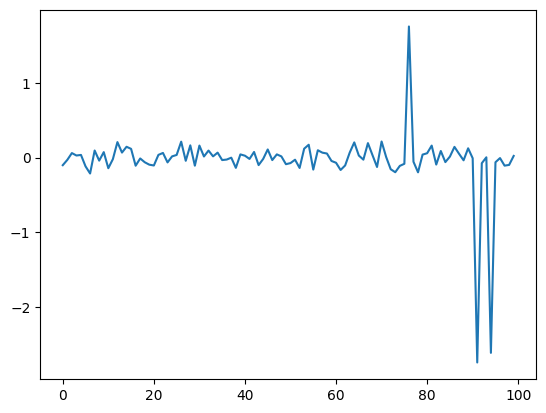

In [27]:
n = 100
p = n
datax = gen_data(n,p,pi0,var0,var1,sigma2,XI=True)
plt.plot(datax['beta'])

In [32]:
fit = ssvs_I_fast(datax['y'],pi0,var0,var1,sigma2,
n_burnin=1000,
n_post=5000,
printevery = 1000)

drawing sample 0
drawing sample 1000
drawing sample 2000
drawing sample 3000
drawing sample 4000
drawing sample 5000


In [35]:
pred_q975 = np.apply_along_axis(np.quantile,0,fit['beta'],q=0.975)
pred_q025 = np.apply_along_axis(np.quantile,0,fit['beta'],q=0.025)
pm = np.apply_along_axis(np.mean,0,fit['beta'])
# get true posterior mean, and credible set
true_pm, true_q025,true_q975 = computeNormalStats_vec(np.sqrt(sigma2),np.sqrt(var0),np.sqrt(var1),1-pi0,datax['y'])


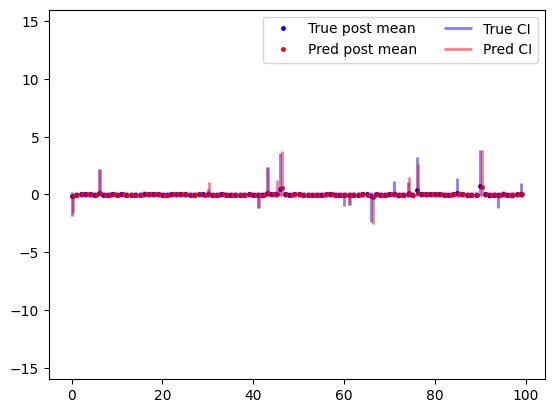

In [36]:
idx = np.arange(n)
order_idx = np.argsort(datax['beta'])
plt.subplot()
plt.plot(idx, true_pm[order_idx], '.b', ms=5)
plt.plot(idx+0.3, pm[order_idx], '.r', ms=5)
plt.vlines(idx, true_q025[order_idx], true_q975[order_idx], color='blue', alpha=0.5, lw=2)
plt.vlines(idx+0.3, pred_q025[order_idx], pred_q975[order_idx], color='red', alpha=0.5, lw=2)
plt.legend(['True post mean', 'Pred post mean', 'True CI', 'Pred CI'], ncol=2)
plt.ylim(-16,16)
plt.show()

drawing sample 0
drawing sample 1000
drawing sample 2000
drawing sample 3000
drawing sample 4000
drawing sample 5000


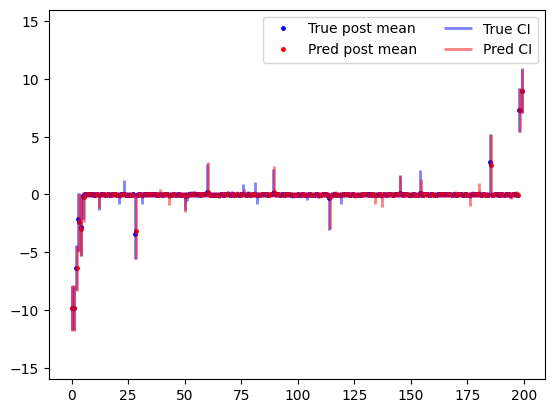

In [37]:
n = 200
p = n
datax = gen_data(n,p,pi0,var0,var1,sigma2,XI=True)

fit = ssvs_I_fast(datax['y'],pi0,var0,var1,sigma2,
n_burnin=1000,
n_post=5000,
printevery = 1000)

pred_q975 = np.apply_along_axis(np.quantile,0,fit['beta'],q=0.975)
pred_q025 = np.apply_along_axis(np.quantile,0,fit['beta'],q=0.025)
pm = np.apply_along_axis(np.mean,0,fit['beta'])
true_pm, true_q025,true_q975 = computeNormalStats_vec(np.sqrt(sigma2),np.sqrt(var0),np.sqrt(var1),1-pi0,datax['y'])


idx = np.arange(n)
order_idx = np.argsort(datax['beta'])
plt.subplot()
plt.plot(idx, true_pm[order_idx], '.b', ms=5)
plt.plot(idx+0.3, pm[order_idx], '.r', ms=5)
plt.vlines(idx, true_q025[order_idx], true_q975[order_idx], color='blue', alpha=0.5, lw=2)
plt.vlines(idx+0.3, pred_q025[order_idx], pred_q975[order_idx], color='red', alpha=0.5, lw=2)
plt.legend(['True post mean', 'Pred post mean', 'True CI', 'Pred CI'], ncol=2)
plt.ylim(-16,16)
plt.show()